In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Function definitions

In [2]:
def RMSE(y_true, y_pred):
    """
        Relative mean squared error (RMSE)
    """
    numerator = np.sqrt(np.mean(np.power((y_true-y_pred),2)))
    denominator = np.sqrt(np.mean(np.power(y_true-np.mean(y_true), 2)))
    rmse = numerator / denominator
    return rmse

In [3]:
def CV(model, X, y, K, plot, **kwargs):
    """
        Cross-validation
    """
    
    kf = KFold(K, shuffle=True)

    # OPTIONAL PLOT
    if plot:
        fig, axarr = plt.subplots(2,5, figsize=(13,8))
        axarr = axarr.flatten()
        
    train_error = []
    test_error = []
    k = 0
    for train_idx, test_idx in kf.split(X):
        # Create k'th model for k'th fold
        modelk = model(**kwargs)

        # Split into training set and test set
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Fit model on training data
        modelk.fit(X_train, y_train)

        # Calculate RMSE
        train_pred = modelk.predict(X_train)
        test_pred = modelk.predict(X_test)
        train_error.append(RMSE(y_train, train_pred))
        test_error.append(RMSE(y_test, test_pred))

        # OPTIONAL PLOT
        if plot:
            axarr[k].plot(y_test, label="True")
            axarr[k].plot(test_pred, label="Prediction")
            axarr[k].set_title("RMSE: " + '{0:.6f}'.format(test_error[k]))

        k += 1
    
    # OPTIONAL PLOT
    if plot:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
    return np.mean(train_error), np.mean(test_error)

# 1. Data preprocessing and cleaning

## 1.1 Loading data and transforming X100

In [4]:
data = pd.read_csv("Case1_Data.csv")
data["X101"] = (data["X100"].values=="A")*1
data["X102"] = (data["X100"].values=="B")*1
data["X103"] = (data["X100"].values=="C")*1
del data["X100"]

## 1.2 Cleaning data

In [5]:
data.describe()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X93,X94,X95,X96,X97,X98,X99,X101,X102,X103
count,100.000000,1092.000000,1096.000000,1095.000000,1097.000000,1096.000000,1096.000000,1095.000000,1092.000000,1095.000000,...,1094.000000,1097.000000,1091.000000,1090.000000,1094.000000,1091.000000,1096.000000,1100.000000,1100.000000,1100.000000
mean,4.991602,-3.641462,8.990355,-5.069977,-7.015045,0.072840,-4.314877,-5.456011,9.304994,7.111225,...,-0.832374,2.688553,1.925158,11.569519,-0.067116,4.318291,-2.732569,0.340000,0.340909,0.319091
std,2.414537,0.282584,0.121137,0.105436,0.340105,0.503032,0.664614,0.273927,0.095785,0.425699,...,0.059573,0.799958,1.090524,0.055043,0.730636,0.175764,0.085847,0.473924,0.474230,0.466336
min,-0.944532,-4.594126,8.582721,-5.426381,-8.165649,-1.627870,-6.550325,-6.377034,8.981696,5.674677,...,-1.033147,-0.012543,-1.743911,11.384005,-2.535141,3.726947,-3.021721,0.000000,0.000000,0.000000
25%,3.356174,-3.831189,8.908915,-5.140014,-7.239486,-0.257051,-4.761447,-5.640342,9.242020,6.829372,...,-0.872257,2.146172,1.188647,11.532567,-0.548406,4.200258,-2.790394,0.000000,0.000000,0.000000
50%,5.228254,-3.644630,8.991774,-5.071288,-7.019211,0.066681,-4.307042,-5.452841,9.303918,7.103198,...,-0.831616,2.698297,1.938475,11.570548,-0.077311,4.320892,-2.731337,0.000000,0.000000,0.000000
75%,6.345374,-3.451549,9.070028,-4.998758,-6.786409,0.412495,-3.877892,-5.276070,9.369462,7.397572,...,-0.793378,3.213777,2.657293,11.606114,0.425581,4.434595,-2.675960,1.000000,1.000000,1.000000
max,10.952595,-2.691022,9.399897,-4.714259,-5.869745,1.770611,-2.068863,-4.531083,9.627082,8.546110,...,-0.631194,5.393991,5.600894,11.755159,2.391165,4.912936,-2.442205,1.000000,1.000000,1.000000


Some of the columns are missing values, hence not all columns have 100 observations.

#### Checking for NaN values

In [6]:
## FIND NAN VALUES
data[data.iloc[:,1:].isnull().any(axis=1)]

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X93,X94,X95,X96,X97,X98,X99,X101,X102,X103
0,6.498576,-4.071886,9.175652,-5.230964,-7.535620,-0.695278,-3.298641,-5.037638,9.158799,6.462640,...,-0.741496,3.910360,3.585373,11.653309,-1.183291,4.587483,-2.601233,0,0,1
1,10.952595,-3.945932,9.121568,-5.183833,-7.383668,-0.470353,-3.595241,-5.159810,9.201513,6.652682,...,-0.768099,3.552535,3.099266,11.628744,-0.857250,4.508990,-2.639587,0,0,1
7,3.335443,-4.039563,9.161773,-5.218869,-7.496625,-0.637557,-3.374756,-5.068991,9.169761,6.511409,...,-0.748323,3.818533,3.460626,11.647005,-1.099621,4.567340,-2.611075,0,1,0
9,5.638672,-4.136850,9.203546,-5.255273,-7.613991,-0.811286,-3.145664,-4.974626,9.136769,6.364622,...,-0.727775,4.094914,3.836091,11.665978,-1.351453,4.627968,-2.581451,0,0,1
10,6.767690,-3.712200,9.021206,-5.096373,-7.101695,-0.052966,-4.145636,-5.386522,9.280777,7.005339,...,-0.817465,2.888527,2.197208,11.583161,-0.252221,4.363332,-2.710761,1,0,0
13,1.170723,NaN,8.947571,-5.032205,-6.894814,0.253266,-4.549454,-5.552858,9.338932,7.264080,...,-0.853684,2.401352,1.535378,11.549717,0.191681,4.256464,-2.762980,0,1,0
15,3.791562,-3.701462,9.016595,-5.092355,-7.088740,-0.033790,-4.170923,-5.396938,9.284419,7.021542,...,-0.819733,2.858020,2.155764,11.581067,-0.224424,4.356640,-2.714031,1,0,0
19,4.613596,-3.439242,8.904000,-4.994235,-6.772397,0.434472,-4.788404,-5.651284,9.373344,7.417184,...,-0.875116,2.113078,1.143755,11.529927,0.454350,4.193228,-2.793880,0,0,1
24,6.008278,-3.235781,8.816635,-4.918102,-6.526943,0.797803,-5.267516,-5.848634,9.442342,7.724168,...,-0.918089,1.535066,0.358523,11.490247,0.981021,4.066434,-2.855836,0,0,1
26,5.813845,-3.798193,9.058130,-5.128551,-7.205436,-0.206528,-3.943138,-5.303112,9.251615,6.875592,...,-0.799302,3.132824,2.529087,11.599932,-0.474819,4.416922,-2.684575,0,0,1


#### Replacing NaN values with mean value of corresponding column.

In [7]:
data_clean = data
data_clean.iloc[:,1:] = data_clean.iloc[:,1:].fillna(data_clean.iloc[:,1:].mean())#.values;

X = data_clean[data_clean["Y"].notnull()].iloc[:,1:].values
y = data_clean[data_clean["Y"].notnull()]["Y"]
y = y.values

Xn = data_clean[data_clean["Y"].isnull()].iloc[:,1:].values
yn = data_clean["Y"][data_clean["Y"].isnull()].values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Xn shape:", Xn.shape)
print("yn shape:", yn.shape)

X shape: (100, 102)
y shape: (100,)
Xn shape: (1000, 102)
yn shape: (1000,)


## 1.3 Standardization of X

In [8]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
Xn = (Xn - Xn.mean(axis=0)) / Xn.std(axis=0)

# 2 Data Modelling

In [9]:
model_scores = []
K = 10

## 2.1 OLS

In [10]:
## OLS ##
reg_ols = linear_model.LinearRegression

train_error, test_error = CV(reg_ols, X, y, K, fit_intercept=True, plot=False)
model_scores.append({"model":"OLS", "lambda":0, "train_error":train_error, "test_error":test_error})
print("train RMSE={:.3f}\t test RMSE={:.3f}".format(train_error, test_error))

train RMSE=0.833	 test RMSE=7132600943852.889


## 2.2 LARS

C:\Users\amont\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=3.574e-05, with an active set of 36 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\amont\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=3.574e-05, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\amont\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=3.574e-05, with an active set of 36 regressors, and the smallest cholesky

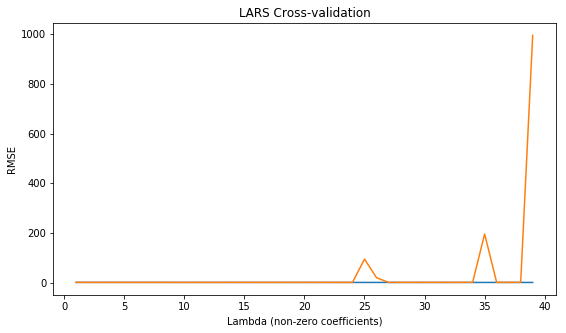

In [11]:
## LARS ##
reg_lars = linear_model.Lars

lambdas = range(1,40,1)
train_errors, test_errors = [], []
for lambda_ in lambdas:
    train_error, test_error = CV(reg_lars, X, y, K, n_nonzero_coefs=lambda_, fit_intercept=True, plot=False)
    train_errors.append(train_error)
    test_errors.append(test_error)
    model_scores.append({"model":"LARS", "lambda":lambda_, "train_error":train_error, "test_error":test_error})

plt.figure(figsize=(9,5))
plt.plot(lambdas, train_errors)
plt.plot(lambdas, test_errors)
plt.title("LARS Cross-validation")
plt.xlabel("Lambda (non-zero coefficients)")
plt.ylabel("RMSE")
plt.savefig("lars_cv.png")
plt.show()

## 2.3 RIDGE

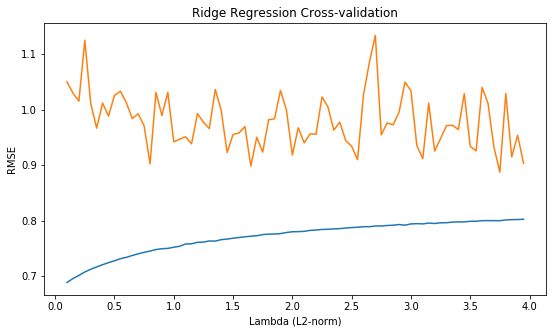

In [12]:
## RIDGE ##
reg_ridge = linear_model.Ridge

lambdas = np.arange(0.1,4,0.05)
train_errors, test_errors = [], []
for lambda_ in lambdas:
    train_error, test_error = CV(reg_ridge, X, y, K, alpha=lambda_, fit_intercept=True, plot=False)
    train_errors.append(train_error)
    test_errors.append(test_error)
    model_scores.append({"model":"RIDGE", "lambda":lambda_, "train_error":train_error, "test_error":test_error})

plt.figure(figsize=(9,5))
plt.plot(lambdas, train_errors)
plt.plot(lambdas, test_errors)
plt.title("Ridge Regression Cross-validation")
plt.xlabel("Lambda (L2-norm)")
plt.ylabel("RMSE")
plt.savefig("ridge_cv.png")
plt.show()

## 2.4 ELASTIC NET

In [13]:
## ELASTIC NET ##
reg_elastic = linear_model.ElasticNet

lambdas = np.arange(0.1, 1.5, 0.05)
kappas = np.arange(0.1, 1, 0.05)
for lambda_ in lambdas:
    for kappa in kappas:
        train_error, test_error = CV(reg_elastic, X, y, K, alpha=lambda_, l1_ratio=kappa, max_iter=1000, fit_intercept=True, plot=False)
        model_scores.append({"model":"ELASTIC", "lambda":lambda_, "kappa":kappa, "train_error":train_error, "test_error":test_error})

In [14]:
elastics = sorted(list(filter(lambda x: x["model"]=="ELASTIC", model_scores)), key=lambda x:x["test_error"])

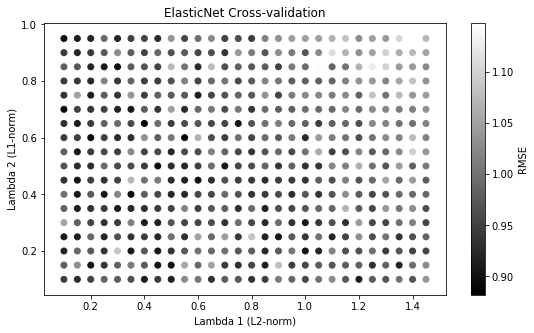

In [15]:
lambdas = list(map(lambda x: x["lambda"], elastics))
kappas = list(map(lambda x: x["kappa"], elastics))
tste = list(map(lambda x: x["test_error"], elastics))

plt.figure(figsize=(9,5))
plt.scatter(lambdas, kappas, c=tste)
plt.title("ElasticNet Cross-validation")
plt.xlabel("Lambda 1 (L2-norm)")
plt.ylabel("Lambda 2 (L1-norm)")
plt.gray()
cbar= plt.colorbar()
cbar.ax.set_ylabel("RMSE")
plt.savefig("elastic_cv.png")
plt.show()

## 2.5 Best model

### top 5

In [16]:
top5 = sorted(model_scores, key=lambda x: x["test_error"])[:5]
print("Top 5 models:")
top5

Top 5 models:


[{'kappa': 0.6000000000000002,
  'lambda': 0.55000000000000016,
  'model': 'ELASTIC',
  'test_error': 0.882029048161586,
  'train_error': 0.87427480283041914},
 {'kappa': 0.65000000000000013,
  'lambda': 0.40000000000000013,
  'model': 'ELASTIC',
  'test_error': 0.88353036693714171,
  'train_error': 0.86404171439598976},
 {'lambda': 3.7500000000000013,
  'model': 'RIDGE',
  'test_error': 0.88728376198049064,
  'train_error': 0.79979436948526883},
 {'kappa': 0.70000000000000018,
  'lambda': 0.10000000000000001,
  'model': 'ELASTIC',
  'test_error': 0.89102134484405882,
  'train_error': 0.84645930480617548},
 {'kappa': 0.40000000000000013,
  'lambda': 0.35000000000000009,
  'model': 'ELASTIC',
  'test_error': 0.89104542141385623,
  'train_error': 0.85659217060996884}]

### top 1

In [17]:
top1 = sorted(model_scores, key=lambda x: x["test_error"])[0]
print("Best model:")
top1

Best model:


{'kappa': 0.6000000000000002,
 'lambda': 0.55000000000000016,
 'model': 'ELASTIC',
 'test_error': 0.882029048161586,
 'train_error': 0.87427480283041914}

### Choose with $+1\sigma$

In [18]:
cv_std = np.std(list(map(lambda x: x["test_error"], elastics)))
print("Test error standard deviation:", cv_std)

onestd = elastics[0]["test_error"] + cv_std
print("Choose least complex model closest to a performance of:", onestd)

top1std = list(filter(lambda x: x["test_error"] > onestd, elastics))[0]
top1std

Test error standard deviation: 0.0469087042282
Choose least complex model closest to a performance of: 0.92893775239


{'kappa': 0.6000000000000002,
 'lambda': 0.35000000000000009,
 'model': 'ELASTIC',
 'test_error': 0.92901262480742341,
 'train_error': 0.85982353128038458}

In [19]:
model1std = linear_model.ElasticNet(alpha=top1std["lambda"], l1_ratio=top1std["kappa"])
model1std.fit(X, y)

ElasticNet(alpha=0.35000000000000009, copy_X=True, fit_intercept=True,
      l1_ratio=0.6000000000000002, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
predn = model1std.predict(Xn)

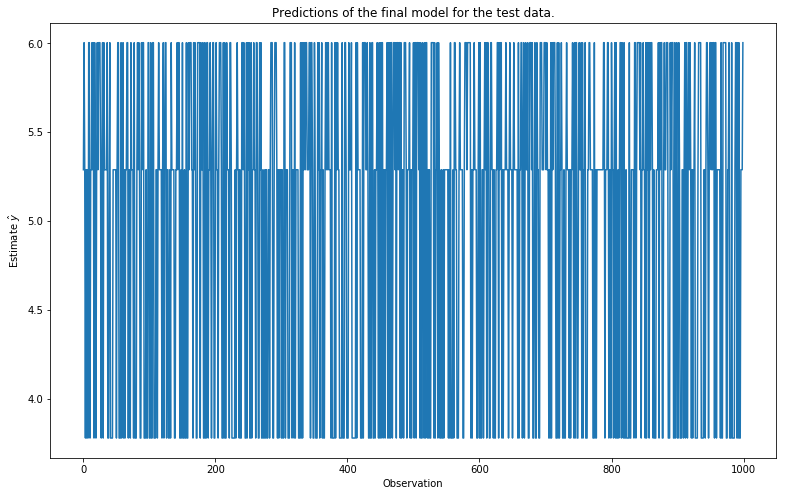

In [21]:
fig = plt.figure(figsize=(13,8))
plt.plot(predn)
plt.title("Predictions of the final model for the test data.")
plt.ylabel("Estimate $\hat{y}$")
plt.xlabel("Observation")
plt.savefig("test_estimates.png")
plt.show()